In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def create_dataset(dataset, lookback=1):
    dataX = []
    dataY = []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        dataY.append(dataset[i+lookback,0])
    return np.array(dataX),np.array(dataY)

In [3]:
def graph_predictions(name,l,df_original,y_train_pr,y_test_pr):
    plt.plot(df_original) #los datos originales
    #calculo meses de resultados de train y test, tengo cuidado con el delay l de los dias
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.legend()
    plt.grid()
    plt.savefig(str(name)+'.pdf')
    plt.show()

In [4]:
def first_model(l=1,dp=0,graph=False,name=''):
    #punto 1: cargo los datos y les hago un primer formatting
    file_dir = 'airline-passengers.csv'
    data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''])
    df = pd.DataFrame(data)
    df = df.drop(columns=['Month']) #no hace falta esta columna para nada
    df = df.to_numpy() #me paso a numpy array
    df_original = np.copy(df)
    #punto 2: normalizo entre 0 y 1
    scaling = MinMaxScaler(feature_range=(0,1))
    df = scaling.fit_transform(df)
    #punto 3: agrego ruido gaussiano pedido
    df += np.random.normal(0,0.02,df.shape)
    #punto 4: dividir en conjuntos de train y test
    train_samples = int(0.5*df.shape[0])
    d_tr = df[:train_samples]
    d_ts = df[train_samples:]
    x_train,y_train = create_dataset(d_tr,l)
    x_test,y_test = create_dataset(d_ts,l)
    #punto 5: ajustar los datos para la capa LSTM (samples, time, features)
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    #punto 6: crear el modelo
    model = keras.Sequential()
    model.add(keras.layers.LSTM(4, input_shape=(1,l),recurrent_dropout=dp)) #input_shape = (1,l) sin el samples, analogo a redes anteriores
    model.add(keras.layers.Dense(1))
    #punto 7: entrenar la red
    model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) #no metrics porque seria mse, compilo
    history = model.fit(x_train, y_train,epochs=100,validation_data=(x_test,y_test),batch_size=1,verbose=0) #entreno el modelo
    #punto 8: realizar predicciones
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    #invertir predicciones
    y_train_pr = scaling.inverse_transform(y_train_pr)
    y_train = scaling.inverse_transform([y_train])
    y_test_pr = scaling.inverse_transform(y_test_pr)
    y_test = scaling.inverse_transform([y_test])
    #calcular el mse para test
    mse_train = mean_squared_error(y_train[0], y_train_pr[:,0])
    mse_test = mean_squared_error(y_test[0], y_test_pr[:,0])
    print('MSE para train dataset:',round(mse_train,1))
    print('MSE para test dataset:',round(mse_test,1))
    #grafico
    if graph == True:
        graph_predictions(name,l,df_original,y_train_pr,y_test_pr)
    return history,mse_train,mse_test

MSE para train dataset: 574.8
MSE para test dataset: 2640.0


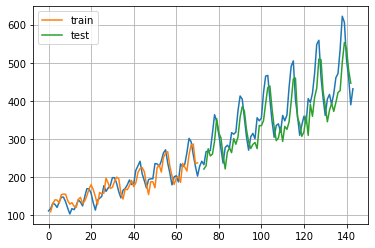

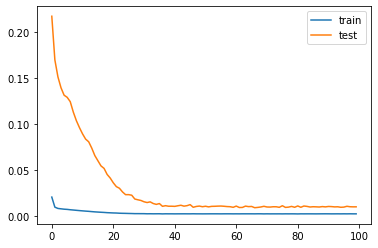

In [5]:
#inciso 8 en el que hago con l=1 una vez la prediccion
def inc_8():
    dp = 0
    l = 1
    name = 'ej1_8_l1'
    history,mse_train,mse_test = first_model(l=l,dp=dp,graph=True,name=name)
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='test')
    plt.legend()
    plt.savefig('ej1_8_l1_loss.pdf')
inc_8()

In [ ]:
#inciso 9 en el que hago con l=[1,10] para ver como va con las predicciones, promedia 10 veces
def inc_9():
    dp = 0
    ls = np.arange(1,13)
    mean_mse_tr = []
    mean_mse_ts = []
    rep_max = 10
    for l in ls:
        print('En l: ',l,'\n')
        i = 0
        aux_tr = 0
        aux_ts = 0
        while i < rep_max:
            history,mse_train,mse_test = history,mse_train,mse_test = first_model(l=l,dp=dp)
            aux_tr += mse_train
            aux_ts += mse_test
            i += 1
        mean_mse_tr.append(aux_tr/10)
        mean_mse_ts.append(aux_ts/10)
    plt.plot(ls,mean_mse_tr,'-ob',label='train')
    plt.legend()
    plt.savefig('ej9_train_l.pdf')
    plt.figure()
    plt.plot(ls,mean_mse_ts,'-or',label='test')
    plt.legend()
    plt.savefig('ej9_test_l.pdf')
inc_9()

En l:  1 

MSE para train dataset: 674.8
MSE para test dataset: 3389.4
MSE para train dataset: 546.7
MSE para test dataset: 2474.1
MSE para train dataset: 562.1
MSE para test dataset: 3314.6
MSE para train dataset: 541.6
MSE para test dataset: 2755.4
MSE para train dataset: 542.7
MSE para test dataset: 2689.0
MSE para train dataset: 540.1
MSE para test dataset: 2343.5
MSE para train dataset: 562.0
MSE para test dataset: 2435.8
MSE para train dataset: 506.9
MSE para test dataset: 2380.1
MSE para train dataset: 453.4
MSE para test dataset: 2605.6
MSE para train dataset: 389.5
MSE para test dataset: 1974.0
En l:  2 

MSE para train dataset: 468.1
MSE para test dataset: 4075.0
MSE para train dataset: 601.0
MSE para test dataset: 2886.0
MSE para train dataset: 616.1
MSE para test dataset: 5089.9
MSE para train dataset: 566.8
MSE para test dataset: 2689.8
MSE para train dataset: 572.6
MSE para test dataset: 3840.7
MSE para train dataset: 575.1
MSE para test dataset: 4532.0
MSE para train dat